# Nettoyage des données

**Sommaire**

1. Chargement des données brut
2. Comptage du nombre de données manquantes
3. Nettoyage et remplissage des jeux de données

In [154]:
%load_ext autoreload
%autoreload
%env ROOT_PATH=../

import logging
import sys

sys.path.insert(0, '../')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import matplotlib.pyplot as plt
import pandas as pd

from lib.data.accidents import loaders
from lib import utils
from lib.constant import Datasets, to_csv_kwargs, read_csv_kwargs
from lib.features import cleaning as clean, dtypes as feat_dtypes, accidents as acc

get_path_raw = '../data/raw/accidents/{}.csv'.format
get_path_interim = '../data/interim/accidents/{}.csv'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: ROOT_PATH=../


## Chargement des données brut

Les données proviennent du site [data.gouv.fr](https://www.data.gouv.fr/fr/datasets), la platforme opendata du gouvernement français. Les jeux de données que j'utilise ici ce trouvent [à cette adresse](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2019/).

Il s'agit d'un ensemble de fichier au format csv rassemblant les informations collectées par les force de l'ordre de 2006 à 2019. Pour chaque année, les données sont séparées en 4 fichiers :

- **caractériqtiques** : informations générales sur l'accident (date, conditions météo, localisation...)
- **lieux** : informations sur la route (type de route, aménagement, nombre de vois...)
- **véhicules** : informations sur les véhicules impliqués (catégorie, obstacle percuté, manoeuvre avant accident...)
- **usagers** : informations sur les personnes impliquées (sexe, date de naissance, place dans le véhicule...)

In [3]:
for data_name in Datasets.list_all():
    out_path = get_path_raw(data_name)
    if not utils.is_file_exists_locally(out_path):
        data = loaders.get_raw_dataset(data_name)
        data.to_csv(out_path, **to_csv_kwargs)

INFO:root:caracs - 2005 (https://www.data.gouv.fr/fr/datasets/r/a47866f7-ece1-4de8-8d31-3a1b4f477e08): 87026 lines
INFO:root:caracs - 2019 (https://www.data.gouv.fr/fr/datasets/r/e22ba475-45a3-46ac-a0f7-9ca9ed1e283a): 58840 lines
INFO:root:caracs - 2018 (https://www.data.gouv.fr/fr/datasets/r/6eee0852-cbd7-447e-bd70-37c433029405): 57783 lines
INFO:root:caracs - 2017 (https://www.data.gouv.fr/fr/datasets/r/9a7d408b-dd72-4959-ae7d-c854ec505354): 60701 lines
INFO:root:caracs - 2016 (https://www.data.gouv.fr/fr/datasets/r/96aadc9f-0b55-4e9a-a70e-c627ed97e6f7): 59432 lines
INFO:root:users - 2005 (https://www.data.gouv.fr/fr/datasets/r/cecdbd46-11f2-41fa-b0bd-e6e223de6b3c): 197498 lines
INFO:root:users - 2019 (https://www.data.gouv.fr/fr/datasets/r/36b1b7b3-84b4-4901-9163-59ae8a9e3028): 132977 lines
INFO:root:users - 2018 (https://www.data.gouv.fr/fr/datasets/r/72b251e1-d5e1-4c46-a1c2-c65f1b26549a): 130169 lines
INFO:root:users - 2017 (https://www.data.gouv.fr/fr/datasets/r/07bfe612-0ad9-48e

## Comptage du nombre de données manquantes

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (4,10,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/caracs.csv: 323782 lines loaded (22.86)Mb


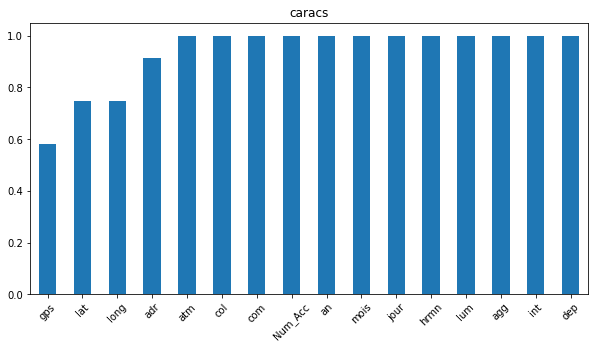

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/users.csv: 730087 lines loaded (28.55)Mb


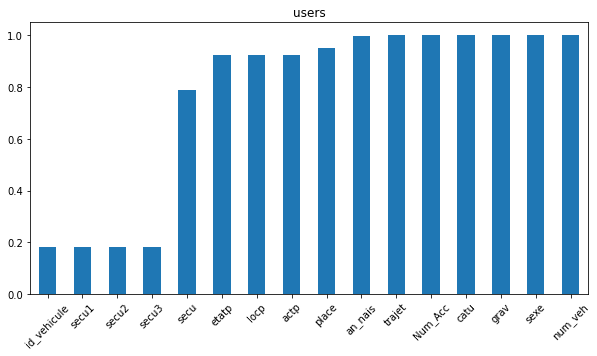

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/locations.csv: 323782 lines loaded (27.79)Mb


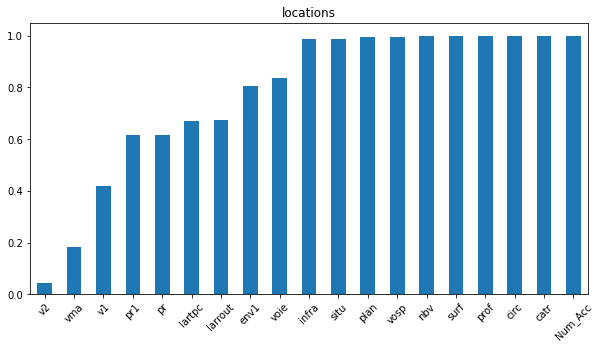

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/vehicles.csv: 554820 lines loaded (19.05)Mb


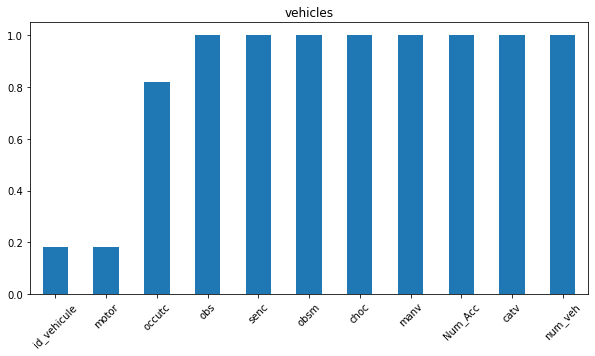

In [61]:
for data_name in Datasets.list_all():
    path = get_path_raw(data_name)
    dtypes = loaders.dtypes(data_name, base_path='../')
    data = utils.get_dataset(path, dtypes=dtypes)
    nas_count = utils.count_na(data)
    nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=data_name)
    plt.show()

## Nettoyage et remplissage des jeux de données

### Caractéristiques

* supression de la colonne `gps`
* création d'une colonne `datetime` ainsi que des colonnes `year`, `month`, `day`, `hour` et `weekday`. `weekday` contient le jour de la semaine (0 = lundi, 6 = dimanche)
* typage de toutes les colonnes. L'année est écrite sur 4 chiffres

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (4,10,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/caracs.csv: 323782 lines loaded (22.86)Mb


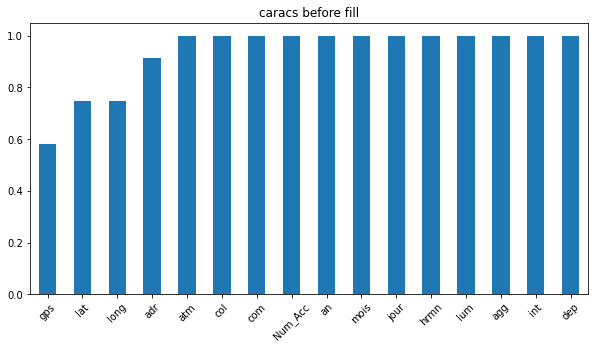

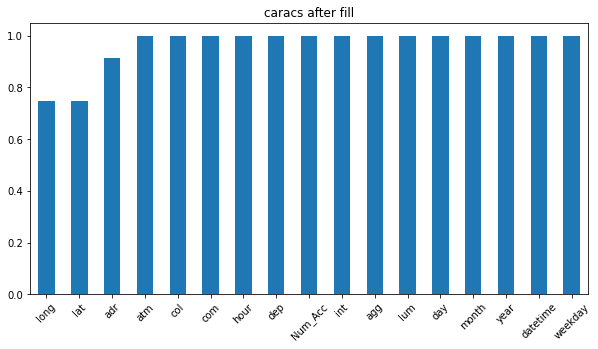

In [74]:
path = get_path_raw(Datasets.CARACS)
dtypes = loaders.dtypes(Datasets.CARACS, base_path='../')
data = utils.get_dataset(path, dtypes=dtypes)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.CARACS + ' before fill')
plt.show()

data = clean.clean_caracs_dataset(data, dtypes_base_path='../')

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.CARACS + ' after fill')
plt.show()

data.to_csv(get_path_interim(Datasets.CARACS), **to_csv_kwargs)

### lieux

* rennomage des catégories de la colonne `catr`
* remplissage des manquant par -1 pour les colonnes `infra` et `situ`
* suppression des colonnes `v1`, `v2` car pas assé de données (moins de 20%)
* suppression de la colonne `larrout` car peu de données et la colonne `nbv` (nombre de voies) peut être utilisée à la place
* suppression de la colonne `env1` par manque d'information à son sujet
* remplissage des manquants de la colonne `voie` par une chaine de caratères vide
* les colonnes `pr` et `pr1` (respectivement le numéro du point de repère amont et la distance en mètre à celui-ci) sont typées et nombre flotant. Les valeures manquantes restent en NA
* typage de toutes les colonnes

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (2,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/locations.csv: 323782 lines loaded (27.79)Mb


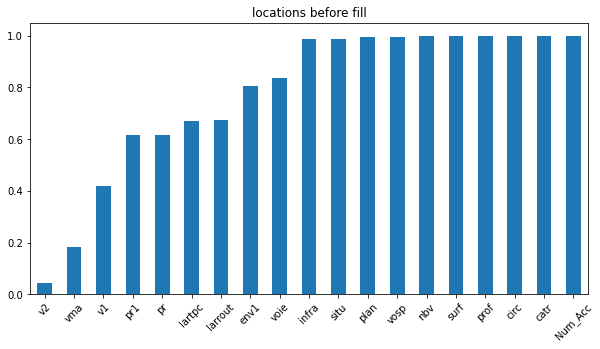

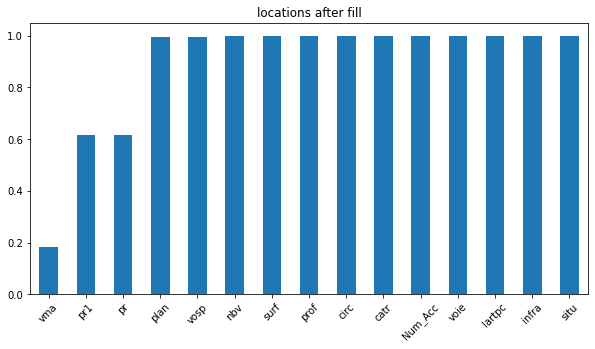

In [75]:
path = get_path_raw(Datasets.LOCATIONS)
dtypes = loaders.dtypes(Datasets.LOCATIONS, base_path='../')
data = utils.get_dataset(path, dtypes=dtypes)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.LOCATIONS + ' before fill')
plt.show()

data = clean.clean_locations_dataset(data)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.LOCATIONS + ' after fill')
plt.show()

data.to_csv(get_path_interim(Datasets.LOCATIONS), **to_csv_kwargs)

### usagers

* renommage des catégories pour les colonnes `sexe`, `catu`, `trajet` et `grav`
* pour la colonne `trajet`, les valeurs non renseignées sont misent à 0
* suppression des colonnes `secu1`, `secu2` et `secu3` par manque de données
* les manquant des colonnes `actp`, `etatp` et `locp` (respectivement l'action du piéton, s'il était accompagné et sa localisation) sont définies à -1 (non renseigné)
* toutes les colonnes sont typées

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/users.csv: 730087 lines loaded (28.55)Mb


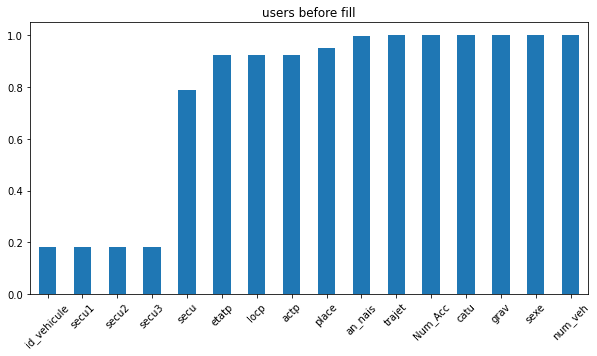

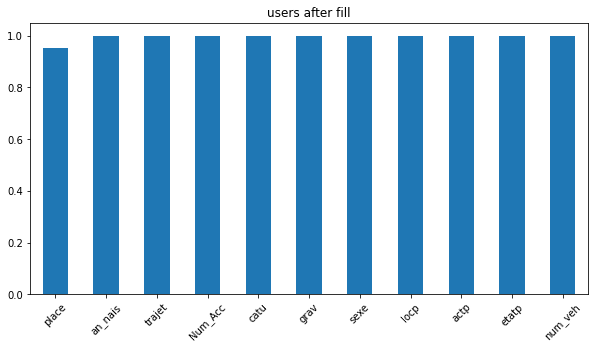

In [76]:
path = get_path_raw(Datasets.USERS)
dtypes = loaders.dtypes(Datasets.USERS, base_path='../')
data = utils.get_dataset(path, dtypes=dtypes)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.USERS + ' before fill')
plt.show()

data = clean.clean_users_dataset(data)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.USERS + ' after fill')
plt.show()

data.to_csv(get_path_interim(Datasets.USERS), **to_csv_kwargs)

### véhicules

* suppression des colonnes `id_vehicule` et `motor` par manque de données
* toutes les colonnes sont typées

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/raw/accidents/vehicles.csv: 554820 lines loaded (19.05)Mb


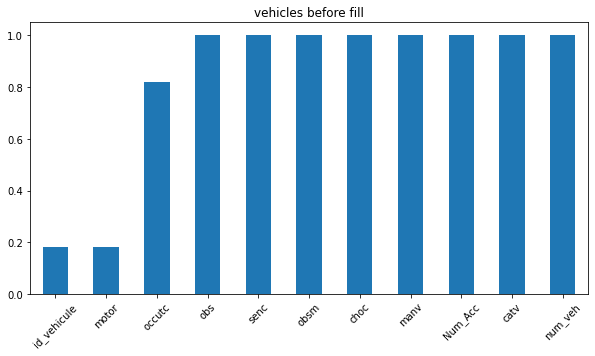

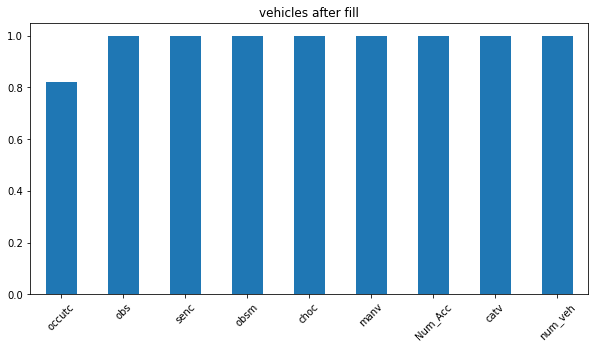

In [77]:
path = get_path_raw(Datasets.VEHICLES)
dtypes = loaders.dtypes(Datasets.VEHICLES, base_path='../')
data = utils.get_dataset(path, dtypes=dtypes)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.VEHICLES + ' before fill')
plt.show()

data = clean.clean_vehicles_dataset(data)

nas_count = utils.count_na(data)
nas_count['filled_rate'].plot.bar(figsize=(10, 5), rot=45, title=Datasets.VEHICLES + ' after fill')
plt.show()

data.to_csv(get_path_interim(Datasets.VEHICLES), **to_csv_kwargs)

## Création de variables

### Accidents

* On merge des datasets `caracs` et `locations` puisque la relation entre les deux est `1:1`
* On ajoute le nombre de victime par gravité (4 colonnes)
* On ajoute une colonne pour le nombre total d'usager impliqué
* On ajoute une colonne gravité de l'accident (état de la victime la plus grave)
* Typage de toutes les colonnes

In [149]:
caracs_dtypes = feat_dtypes.dtypes_clean(Datasets.CARACS, base_path='../')
caracs_df = utils.get_dataset(get_path_interim(Datasets.CARACS), dtypes=caracs_dtypes)

loc_dtypes = feat_dtypes.dtypes_clean(Datasets.LOCATIONS, base_path='../')
loc_df = utils.get_dataset(get_path_interim(Datasets.LOCATIONS), dtypes=loc_dtypes)

usr_dtypes = feat_dtypes.dtypes_clean(Datasets.USERS, base_path='../')
usr_df = utils.get_dataset(get_path_interim(Datasets.USERS), dtypes=usr_dtypes)

acc_df = acc.build_accidents_dataset(caracs_df, loc_df, usr_df, dtypes_base_path='../')
acc_df.to_csv(get_path_interim(Datasets.ACCIDENTS), **to_csv_kwargs)

INFO:root:../data/interim/accidents/caracs.csv: 323782 lines loaded (26.56)Mb
INFO:root:../data/interim/accidents/locations.csv: 323782 lines loaded (15.13)Mb
C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/interim/accidents/users.csv: 730087 lines loaded (20.19)Mb
INFO:root:merge caracs with locations (1 accident = 1 carac = 1 location)
INFO:root:add nb victims by severity (4 columns)
INFO:root:add total victims number column
INFO:root:add acc_severity column


In [150]:
acc_df

,Num_Acc,year,month,day,lum,agg,int,atm,col,com,...,surf,infra,situ,vma,inj_hosp,inj_light,killed,safe,victims_nb,acc_severity
0,200500000001,2005,1,12,3,2,1,1.0,3.0,11,...,1.0,0.0,1.0,NaN,1.0,1.0,0.0,4.0,6.0,inj_hosp
1,200500000002,2005,1,21,1,2,1,1.0,1.0,51,...,1.0,0.0,5.0,NaN,1.0,0.0,0.0,1.0,2.0,inj_hosp
2,200500000003,2005,1,21,3,1,1,2.0,1.0,51,...,2.0,0.0,5.0,NaN,1.0,0.0,0.0,1.0,2.0,inj_hosp
3,200500000004,2005,1,4,1,1,1,1.0,5.0,82,...,1.0,0.0,1.0,NaN,2.0,2.0,0.0,0.0,4.0,inj_hosp
4,200500000005,2005,1,10,3,1,1,3.0,6.0,478,...,2.0,0.0,3.0,NaN,1.0,1.0,0.0,0.0,2.0,inj_hosp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323777,201600059428,2016,12,1,1,2,1,1.0,6.0,611,...,1.0,0.0,1.0,NaN,0.0,1.0,0.0,1.0,2.0,inj_light
323778,201600059429,2016,12,3,1,2,1,1.0,7.0,611,...,1.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0,inj_light
323779,201600059430,2016,12,5,1,2,1,1.0,3.0,611,...,0.0,0.0,1.0,NaN,0.0,1.0,0.0,1.0,2.0,inj_light
323780,201600059431,2016,12,6,1,2,3,1.0,3.0,611,...,1.0,0.0,1.0,NaN,0.0,2.0,0.0,0.0,2.0,inj_light


## Victimes

* ajout de l'âge de la victime (colonne `age`)
* typage de toutes les colonnes

In [151]:
caracs_dtypes = feat_dtypes.dtypes_clean(Datasets.CARACS, base_path='../')
caracs_df = utils.get_dataset(get_path_interim(Datasets.CARACS), dtypes=caracs_dtypes)

usr_dtypes = feat_dtypes.dtypes_clean(Datasets.USERS, base_path='../')
usr_df = utils.get_dataset(get_path_interim(Datasets.USERS), dtypes=usr_dtypes)

victims = acc.build_victims_dataset(caracs_df, usr_df, dtypes_base_path='../')
victims.to_csv(get_path_interim(Datasets.VICTIMS), **to_csv_kwargs)

C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (9,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/interim/accidents/caracs.csv: 323782 lines loaded (26.56)Mb
C:\Users\thomas.marquis\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
INFO:root:../data/interim/accidents/users.csv: 730087 lines loaded (20.19)Mb
